## Setup

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

## Configuration

In [2]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
data_path = "fra.txt" # Path to the data txt file on disk.

## Prepare the data

In [3]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

In [4]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [5]:
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 70
Number of unique output tokens: 93
Max sequence length for inputs: 16
Max sequence length for outputs: 59


In [6]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

In [7]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

In [8]:
encoder_input_data.shape

(10000, 16, 70)

In [9]:
# one-hot representation
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

## Build the model

In [10]:
# Define an input sequence and process it.
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, return_state=True)
# state_h - Hidden State 
# state_c - Cell state from t_1 to t_n
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

2022-04-03 21:33:39.808541: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-03 21:33:39.808862: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


In [13]:
# Set up the decoder, using `encoder_states` as initial state.
# 
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

In [18]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

## Train the model

In [19]:
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
)

Epoch 1/100


2022-04-03 21:46:58.860524: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-03 21:46:59.900733: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-03 21:47:00.114901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-03 21:47:00.304161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-03 21:47:01.074076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  1/125 [..............................] - ETA: 5:22 - loss: 4.5546 - accuracy: 0.0021

2022-04-03 21:47:01.337056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - ETA: 0s - loss: 1.2020 - accuracy: 0.7238

2022-04-03 21:47:05.121790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-03 21:47:05.198699: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-03 21:47:05.229279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - 7s 37ms/step - loss: 1.2020 - accuracy: 0.7238 - val_loss: 1.0655 - val_accuracy: 0.6993
Epoch 2/100
125/125 [==============================] - 4s 31ms/step - loss: 0.8696 - accuracy: 0.7657 - val_loss: 0.8676 - val_accuracy: 0.7642
Epoch 3/100
125/125 [==============================] - 4s 31ms/step - loss: 0.7130 - accuracy: 0.8009 - val_loss: 0.7542 - val_accuracy: 0.7857
Epoch 4/100
125/125 [==============================] - 4s 31ms/step - loss: 0.6096 - accuracy: 0.8238 - val_loss: 0.6839 - val_accuracy: 0.8010
Epoch 5/100
125/125 [==============================] - 4s 31ms/step - loss: 0.5537 - accuracy: 0.8381 - val_loss: 0.6238 - val_accuracy: 0.8183
Epoch 6/100
125/125 [==============================] - 4s 30ms/step - loss: 0.5162 - accuracy: 0.8487 - val_loss: 0.5874 - val_accuracy: 0.8256
Epoch 7/100
125/125 [==============================] - 4s 31ms/step - loss: 0.4871 - accuracy: 0.8561 - val_loss: 0.5577 - val_accuracy: 0.8341
Epoc

125/125 [==============================] - 4s 31ms/step - loss: 0.1293 - accuracy: 0.9591 - val_loss: 0.5388 - val_accuracy: 0.8751
Epoch 58/100
125/125 [==============================] - 4s 31ms/step - loss: 0.1273 - accuracy: 0.9595 - val_loss: 0.5377 - val_accuracy: 0.8751
Epoch 59/100
125/125 [==============================] - 4s 31ms/step - loss: 0.1254 - accuracy: 0.9600 - val_loss: 0.5471 - val_accuracy: 0.8742
Epoch 60/100
125/125 [==============================] - 4s 31ms/step - loss: 0.1234 - accuracy: 0.9609 - val_loss: 0.5472 - val_accuracy: 0.8752
Epoch 61/100
125/125 [==============================] - 4s 31ms/step - loss: 0.1214 - accuracy: 0.9614 - val_loss: 0.5544 - val_accuracy: 0.8743
Epoch 62/100
125/125 [==============================] - 4s 31ms/step - loss: 0.1196 - accuracy: 0.9619 - val_loss: 0.5526 - val_accuracy: 0.8741
Epoch 63/100
125/125 [==============================] - 4s 31ms/step - loss: 0.1181 - accuracy: 0.9623 - val_loss: 0.5582 - val_accuracy: 0.874

In [21]:
# Save model
model.save('seq2seq.h5')

# Visualize your model in https://github.com/lutzroeder/netron

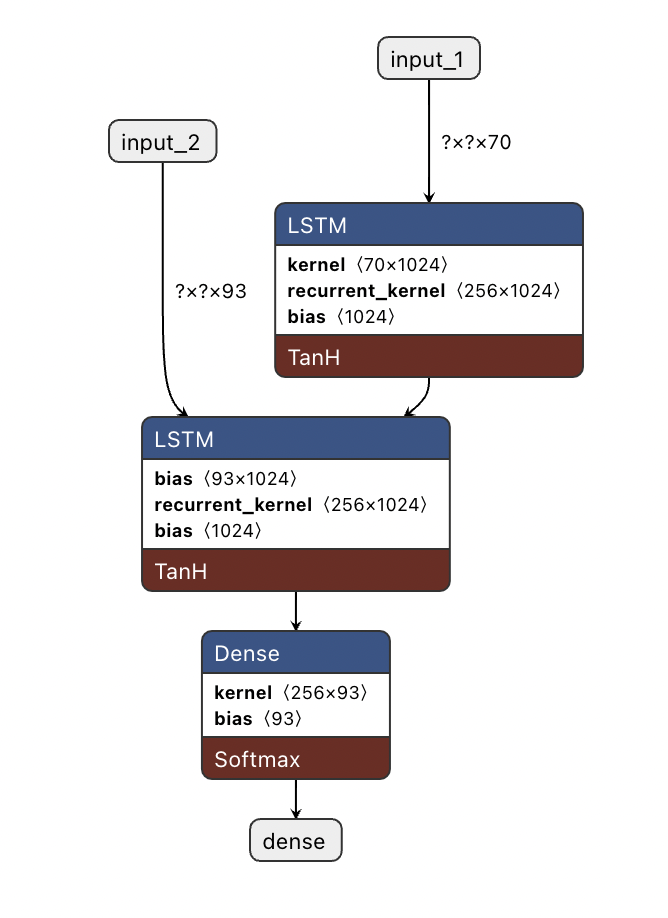

## Run inference (sampling)
1. encode input and retrieve initial decoder state
2. run one step of decoder with this initial state and a "start of sequence" token as target. Output will be the next target token.
3. Repeat with the current target token and current states

In [31]:
# Define sampling models
model = keras.models.load_model("seq2seq.h5")

In [32]:
# Restore the model and construct the encoder and decoder.
encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

In [39]:
decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,))
decoder_state_input_c = keras.Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

In [41]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

In [87]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence

In [88]:
for seq_index in range(20):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)

-
Input sentence: Go.
Decoded sentence: Va !

-
Input sentence: Hi.
Decoded sentence: Salut.

-
Input sentence: Hi.
Decoded sentence: Salut.

-
Input sentence: Run!
Decoded sentence: Lis je tou !

-
Input sentence: Run!
Decoded sentence: Lis je tou !

-
Input sentence: Who?
Decoded sentence: Qui ?

-
Input sentence: Wow!
Decoded sentence: Ça alors !

-
Input sentence: Fire!
Decoded sentence: Les oiseaux chantent.

-
Input sentence: Help!
Decoded sentence: Serrez-moi dans vos bras !

-
Input sentence: Jump.
Decoded sentence: Saute.

-
Input sentence: Stop!
Decoded sentence: Arrêtez-le.

-
Input sentence: Stop!
Decoded sentence: Arrêtez-le.

-
Input sentence: Stop!
Decoded sentence: Arrêtez-le.

-
Input sentence: Wait!
Decoded sentence: Attends !

-
Input sentence: Wait!
Decoded sentence: Attends !

-
Input sentence: Go on.
Decoded sentence: Va au lit !

-
Input sentence: Go on.
Decoded sentence: Va au lit !

-
Input sentence: Go on.
Decoded sentence: Va au lit !

-
Input sentence: Hello

## Reference

https://keras.io/examples/nlp/lstm_seq2seq/